In [1]:
import glob,os
import numpy as np
import pandas as pd
from pandas import DataFrame
from rdkit import Chem,DataStructs
from rdkit.Chem import rdChemReactions,AllChem,Lipinski,Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sb

In [3]:
# Load the data from a csv file
os.chdir('C:\Google Drive\Rob Paton CSU\Project Mihai S0 to T1 predict')

df_Ir = pd.read_csv('Database smiles and wavelength v8 with DOI.csv')    

print('A total of',len(df_Ir['Wavelength']),'datapoints were loaded.')

A total of 336 datapoints were loaded.


In [6]:
# Create new model. If you want to use parameters generated previously, set False here
create_new_model = True

# I need to add something that prints the % of progress of this every 10% and the elapsed time required
# for every 10%

# The number of bits define how many bits the fingerprint will have (i.e. 8 bits will generate fingerprints
# with 8 numbers that are 1 and 0, such as [0 0 1 0 1 1 0 1]). Standard value: 100
range_bits = 160

# This counts the number of different random forest models compared
count_models = 0

# Change to start randomizing 
random_seed = 0

# For Morgan (circular) fingerprints: The radius in these fingerprints defines the number of bonds away from the atom 
# to consider. In this case, the radius is 2, so the fingerprint will consider the connectivity of atoms 
# up to 2 bonds away.The bigger the radius, the wider the connectivity to neighbours from the atoms is considered 
# (i.e. radius 4 consider more structure near to the atoms than radius 2)
# For RDKIT fingerprints: maxPath determines the maximum length of the fragments to consider (i.e. maxPath = 5 will
# take fragments that contain a maximum of 5 atoms). Standard value: 8
range_radius = 6
fp_types = ['Morgan', 'RDKit']

# This parameter adjusts the number of trees used in the RF model. Standard value: 300
range_estimators = 200

if create_new_model == True:
    global_results, bits_used, radius_used, fp_type_used, feature_used, estimator_used, result_average_test = [],[],[],[],[],[],[]
    result_r2_RF_test_30, result_mae_RF_test_30, result_rmse_RF_test_30 = [],[],[]
    result_r2_RF_test_40, result_mae_RF_test_40, result_rmse_RF_test_40 = [],[],[]
    for bit in np.arange(40, range_bits+20, 20):
        for radius in np.arange(2, range_radius+2, 2): 
            for fp_type in fp_types:
                fp_descriptors, wavelength = [], []
                if fp_type == 'Morgan':
                    for i in range(len(df_Ir['Smiles'])):
                        smi = df_Ir['Smiles'][i]
                        if str(smi) != 'nan' and str(smi) != 'None':
                            fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=int(radius), nBits = int(bit))
                            arr = np.zeros((0,), dtype=np.int8)
                            fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
                            fp_descriptors.append(arr)
                            wavelength.append(df_Ir['Wavelength'][i])
                            
                if fp_type == 'RDKit':
                    for i in range(len(df_Ir['Smiles'])):
                        smi = df_Ir['Smiles'][i]
                        if str(smi) != 'nan' and str(smi) != 'None':
                            fp = Chem.RDKFingerprint(Chem.MolFromSmiles(smi), maxPath=int(radius), fpSize=int(bit))
                            arr = np.zeros((0,), dtype=np.int8)
                            fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
                            fp_descriptors.append(arr)
                            wavelength.append(df_Ir['Wavelength'][i])
                            
                y = wavelength
                
                # The feature parameter adjusts the number of variables taken in each split for the RF model.
                # It depends on the number of bits used    
                for feature in np.arange(20, len(fp_descriptors[0])+20, 20):
                    for estimator in np.arange(50, range_estimators+50, 50):
                        RF = RandomForestRegressor(random_state=random_seed,
                                                      n_estimators=estimator, max_features=feature)
                        RF_train = RandomForestRegressor(random_state=random_seed,
                                                      n_estimators=estimator, max_features=feature)

                        # Unscaled version for RF
                        RF.fit(fp_descriptors, y)  
                        y_pred_RF = RF.predict(fp_descriptors)

                        mae_RF = mean_absolute_error(y, y_pred_RF)
                        rmse_RF = np.sqrt(mean_squared_error(y, y_pred_RF))
                        slope, intercept, r_value, p_value, std_err = stats.linregress(y, y_pred_RF)
                        r2_RF = r_value**2

                        count_models = count_models + 1

                        # Splitting the data into train and test for the unscaled values
                        for i in np.arange(0.3, 0.5, 0.1):
                            X_train, X_test, y_train, y_test = train_test_split(fp_descriptors, y, test_size=i, random_state=random_seed)
                            RF_train.fit(X_train, y_train)
                            y_pred_RF_test = RF_train.predict(X_test)

                            mae_RF_test = mean_absolute_error(y_test, y_pred_RF_test)
                            rmse_RF_test = np.sqrt(mean_squared_error(y_test, y_pred_RF_test))
                            slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_pred_RF_test)
                            r2_RF_test = r_value**2
                            if i == 0.3:
                                result_r2_RF_test_30.append(round(r2_RF_test,2))
                                result_mae_RF_test_30.append(round(mae_RF_test,2))
                                result_rmse_RF_test_30.append(round(rmse_RF_test,2))
                                result_from_test30 = mae_RF_test+rmse_RF_test
                            elif i == 0.4:
                                result_from_test40 = mae_RF_test+rmse_RF_test
                                result_r2_RF_test_40.append(round(r2_RF_test,2))
                                result_mae_RF_test_40.append(round(mae_RF_test,2))
                                result_rmse_RF_test_40.append(round(rmse_RF_test,2)) 
    #                         print("R2_test = ", round(r2_RF_test,2), "; MAE_test = ", round(mae_RF_test,2), "; RMSE_test = ", round(rmse_RF_test,2), " kcal/mol with ",round(i*100,2),"% used as test.")

                        bits_used.append(bit)
                        radius_used.append(radius)
                        fp_type_used.append(fp_type)
                        feature_used.append(feature)
                        estimator_used.append(estimator)  
                        # This is how I decide which is the best combination. I sum up the MAE+RMSE of the models using
                        # 30% and 40% of the data as test, and then the results of 30% and 40% are averaged.
                        result_average_test.append((result_from_test30+result_from_test40)/2)

    global_results.append(bits_used) # 0 in the list of lists
    global_results.append(radius_used)
    global_results.append(fp_type_used) # 2 in the list of lists
    global_results.append(feature_used)
    global_results.append(estimator_used)
    global_results.append(result_average_test) # 5 in the list of lists
    global_results.append(result_r2_RF_test_30) 
    global_results.append(result_mae_RF_test_30) # 7 in the list of lists
    global_results.append(result_rmse_RF_test_30)
    global_results.append(result_r2_RF_test_40)
    global_results.append(result_mae_RF_test_40) # 10 in the list of lists
    global_results.append(result_rmse_RF_test_40)  


    # This part prints the total number of points as well as all the paramaters considered for the combinations   
    print("\nUsing the entire dataset with", len(fp_descriptors), "datapoints, and considering", count_models*len(fp_types), "combinations of:")  
    print(fp_types, "types of fingerprints,", np.arange(40, range_bits+20, 20), "bits and", np.arange(2, range_radius+2, 2), "radius for the fingerprints", np.arange(20, len(fp_descriptors[0])+20, 20), "features to split RF (varies with the number of bits) and", np.arange(50, range_estimators+50, 50), "number of trees RF, the 3 best results are:")

    # This part sets the number of worse and the best combinations. (i.e. 3 worse and 3 best combinations if points_ranking=3)
    points_ranking = 3

    ind_highest = np.argpartition(global_results[5], -points_ranking)[-points_ranking:]
    ind_lowest = np.argpartition(global_results[5], points_ranking)[:points_ranking]

    if points_ranking == 1:
        print('\nThe best combination is: ')
    elif points_ranking > 1:
        print('\nThe', points_ranking, 'best combinations are: ')

    # This number will be used to retrieve only the best combination of parameters for the RF
    count_lowest = 1

    # This list will contain the best parameters to use in the RF
    best_results_RF = []
    for i in ind_lowest:
        print('\nBest combination', i+1, ':', str(global_results[0][i]), 'bits,', 'radius', str(global_results[1][i]), ',', 
              str(global_results[2][i]), 'fp_type,', str(global_results[3][i]), 'features,', str(global_results[4][i]), 'estimators.')
        print("R2_test = ", round(global_results[6][i],2), "; MAE_test = ", round(global_results[7][i],2), "; RMSE_test = ", round(global_results[8][i],2), " nm with 30% used as test.")
        print("R2_test = ", round(global_results[9][i],2), "; MAE_test = ", round(global_results[10][i],2), "; RMSE_test = ", round(global_results[11][i],2), " nm with 40% used as test.")
        if count_lowest == 1:
            best_results_RF.append(global_results[0][i]) # bits
            best_results_RF.append(global_results[1][i]) # radius
            best_results_RF.append(global_results[2][i]) # fp_type
            best_results_RF.append(global_results[3][i]) # features
            best_results_RF.append(global_results[4][i]) # estimators
            count_lowest = count_lowest+1

    if points_ranking == 1:
        print('\n...and the worse combination is... ')
    elif points_ranking > 1:
        print('\n...and the', points_ranking, 'worse combinations are... ')

    for i in reversed(ind_highest):
        print('\nWorse combination', i+1, ':', str(global_results[0][i]), 'bits,', 'radius,', str(global_results[1][i]), 
              str(global_results[2][i]), 'fp_type,', str(global_results[3][i]), 'features,', str(global_results[4][i]), 'estimators.')
        print("R2_test = ", round(global_results[6][i],2), "; MAE_test = ", round(global_results[7][i],2), "; RMSE_test = ", round(global_results[8][i],2), " nm with 30% used as test.")
        print("R2_test = ", round(global_results[9][i],2), "; MAE_test = ", round(global_results[10][i],2), "; RMSE_test = ", round(global_results[11][i],2), " nm with 40% used as test.")

    # Now, the results will be included in a csv file. First, I put all the optimized parameters into a dictionary
    RF_param_database = dict ([('Fp_bits', best_results_RF[0]),
        ('Fp_radius', best_results_RF[1]),
        ('Fp_type', best_results_RF[2]),
        ('RF_features', best_results_RF[3]),
        ('RF_estimators', best_results_RF[4])
                        ])
    
    # Then, the parameters are put into a pandas dataframe and into a csv file
    df_params = DataFrame.from_dict(RF_param_database, orient='index')
    df_params = df_params.transpose()
    
    export_param_excel = df_params.to_csv('RF_parameters.csv', index = None, header=True)
    
elif create_new_model == False:
    df_params = pd.read_csv('RF_parameters.csv')

    print('\nThese parameters were successfully loaded for the random forest:',
          '\n\n',df_params['Fp_bits'][0], 'bits and', 'radius', df_params['Fp_radius'][0], 'for generating', 
            df_params['Fp_type'][0], 'fingerprints, and', df_params['RF_features'][0], 'features and', df_params['RF_estimators'][0], 'estimators for the RF model.')


KeyboardInterrupt: 

In [5]:
# (1) Check that scaled and unscaled values lead to the same results
# (2) Check that the script is generating the best model automatically
# (3) Check that SMILES and fingerprints used in the model match each other

# These parameters are optimized previously from the big RF optimizer (it keeps the best parameters)
best_bits = df_params['Fp_bits'][0]
best_radius = df_params['Fp_radius'][0]
best_fp_type = df_params['Fp_type'][0]
best_features = df_params['RF_features'][0]
best_estimators = df_params['RF_estimators'][0]

# This part allows you to try tests
test_mode_x = False
test_mode_y = False

if test_mode_x == False:
    # Generate all the fingerprints with the optimized parameters
    fp_descriptors, wavelength = [], []
    if best_fp_type == 'Morgan':
        for i in range(len(df_Ir['Smiles'])):
            smi = df_Ir['Smiles'][i]
            if str(smi) != 'nan' and str(smi) != 'None':
                fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=int(best_radius), nBits = int(best_bits))
                arr = np.zeros((0,), dtype=np.int8)
                fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
                fp_descriptors.append(arr)
                wavelength.append(df_Ir['Wavelength'][i])

    if best_fp_type == 'RDKit':
        for i in range(len(df_Ir['Smiles'])):
            smi = df_Ir['Smiles'][i]
            if str(smi) != 'nan' and str(smi) != 'None':
                fp = Chem.RDKFingerprint(Chem.MolFromSmiles(smi), maxPath=int(best_radius), fpSize=int(best_bits))
                arr = np.zeros((0,), dtype=np.int8)
                fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
                fp_descriptors.append(arr)
                wavelength.append(df_Ir['Wavelength'][i])

                
if test_mode_x == True:
    print('WARNING! Values obtained using randomly generated X values.')
    fp_descriptors, wavelength = [], []
    for i in range(len(df_Ir['Smiles'])):
        fp = np.random.randint(low=0, high=2, size=best_bits)
        fp_descriptors.append(fp)
        wavelength.append(np.asarray(df_Ir['Wavelength'][i], dtype=np.int8))

y = wavelength

if test_mode_y == True:
    print('WARNING! Values obtained using randomly shuffled y values.')
    random.shuffle(y)
    

# Load the random forest model
RF = RandomForestRegressor(random_state=random_seed,
                              n_estimators=best_estimators, max_features=best_features)
RF_scaled = RandomForestRegressor(random_state=random_seed,
                              n_estimators=best_estimators, max_features=best_features)
RF_train = RandomForestRegressor(random_state=random_seed,
                              n_estimators=best_estimators, max_features=best_features)

print("\nUsing", best_bits, "bits, radius", best_radius, ',', best_features, 'features to split in RF and', best_estimators, 'estimators for RF with', best_fp_type, "fingerprints:")

# Unscaled version for RF
RF.fit(fp_descriptors, y)  
y_pred_RF = RF.predict(fp_descriptors)

mae_RF = mean_absolute_error(y, y_pred_RF)
error_abs = []
for i in range(len(y)):
    error_abs.append(np.absolute(y[i]-y_pred_RF[i]))
SD = np.std(error_abs)
rmse_RF = np.sqrt(mean_squared_error(y, y_pred_RF))

slope, intercept, r_value, p_value, std_err = stats.linregress(y, y_pred_RF)
r2_RF = r_value**2

print("NOT SCALED full dataset: R2 =", round(r2_RF,2), "; MAE =", round(mae_RF,2), "; SD=", round(SD,2), "RMSE =", round(rmse_RF,2), "nm.")

# Scaled version for RF
scaler = StandardScaler()
fp_descriptors_scaled = scaler.fit_transform(fp_descriptors)
RF_scaled.fit(fp_descriptors_scaled, y)  
y_pred_RF_scaled = RF_scaled.predict(fp_descriptors_scaled)

mae_RF_scaled = mean_absolute_error(y, y_pred_RF_scaled)
error_abs_scaled = []
for i in range(len(y)):
    error_abs_scaled.append(np.absolute(y[i]-y_pred_RF_scaled[i]))
SD_scaled = np.std(error_abs_scaled)
rmse_RF_scaled = np.sqrt(mean_squared_error(y, y_pred_RF_scaled))

slope_scaled, intercept_scaled, r_value_scaled, p_value_scaled, std_err_scaled = stats.linregress(y, y_pred_RF_scaled)
r2_RF_scaled = r_value_scaled**2

print("SCALED full dataset: R2_scaled =", round(r2_RF_scaled,2), "; MAE_scaled =", round(mae_RF_scaled,2), "; SD_scaled =", round(SD_scaled,2), "; RMSE_scaled =", round(rmse_RF_scaled,2), "nm.")

# Splitting the data into train and test for the unscaled values and 
# calculation of different parameters with the stats package 
X_train_30, X_test_30, y_train_30, y_test_30, y_pred_RF_train_30, y_pred_RF_test_30 = [],[],[],[],[],[]
X_train_40, X_test_40, y_train_40, y_test_40, y_pred_RF_train_40, y_pred_RF_test_40 = [],[],[],[],[],[]
for i in np.arange(0.3, 0.5, 0.1):
    X_train, X_test, y_train, y_test = train_test_split(fp_descriptors, y, test_size=i, random_state=random_seed)
    RF_train.fit(X_train, y_train)
       
    y_pred_RF_train = RF_train.predict(X_train)
    mae_RF_train = mean_absolute_error(y_train, y_pred_RF_train)
    error_abs_train = []
    for j in range(len(y_train)):
        error_abs_train.append(np.absolute(y_train[j]-y_pred_RF_train[j]))
    SD_train = np.std(error_abs_train)
    rmse_RF_train = np.sqrt(mean_squared_error(y_train, y_pred_RF_train))
    
    y_pred_RF_test = RF_train.predict(X_test)
    mae_RF_test = mean_absolute_error(y_test, y_pred_RF_test)
    error_abs_test = []
    for j in range(len(y_test)):
        error_abs_test.append(np.absolute(y_test[j]-y_pred_RF_test[j]))
    SD_test = np.std(error_abs_test)
    rmse_RF_test = np.sqrt(mean_squared_error(y_test, y_pred_RF_test))
    
    slope_train, intercept_train, r_value_train, p_value_train, std_err_train = stats.linregress(y_train,y_pred_RF_train)
    r2_RF_train = r_value_train**2
    slope_test, intercept_test, r_value_test, p_value_test, std_err_test = stats.linregress(y_test,y_pred_RF_test)
    r2_RF_test = r_value_test**2
    
    # Saves all the data into lists, that way we can plot the results
    if i == 0.3:
        X_train_30 = X_train
        X_test_30 = X_test
        y_train_30 = y_train
        y_test_30 = y_test
        y_pred_RF_train_30 = y_pred_RF_train
        y_pred_RF_test_30 = y_pred_RF_test
        r2_RF_train_30 = r2_RF_train
        r2_RF_test_30 = r2_RF_test
        mae_RF_train_30 = mae_RF_train
        mae_RF_test_30 = mae_RF_test
        SD_train_30 = SD_train
        SD_test_30 = SD_test
        rmse_RF_train_30 = rmse_RF_train
        rmse_RF_test_30 = rmse_RF_test
        i_30 = i
        
    if i == 0.4:
        X_train_40 = X_train
        X_test_40 = X_test
        y_train_40 = y_train
        y_test_40 = y_test
        y_pred_RF_train_40 = y_pred_RF_train
        y_pred_RF_test_40 = y_pred_RF_test
        r2_RF_train_40 = r2_RF_train
        r2_RF_test_40 = r2_RF_test
        mae_RF_train_40 = mae_RF_train
        mae_RF_test_40 = mae_RF_test
        SD_train_40 = SD_train
        SD_test_40 = SD_test
        rmse_RF_train_40 = rmse_RF_train
        rmse_RF_test_40 = rmse_RF_test
        i_40 = i
        
    # Prints the results    
    print("\nWith",round(i*100,2),"% used as test:",
          "\nR2_train =", round(r2_RF_train,2), "; MAE_train =", round(mae_RF_train,2), "; SD_train =", round(SD_train,2), "; RMSE_train =", round(rmse_RF_train,2), "nm.",
          "\nR2_test =", round(r2_RF_test,2), "; MAE_test =", round(mae_RF_test,2), "; SD_test =", round(SD_test,2), "; RMSE_test =", round(rmse_RF_test,2), "nm.")
    


Using 140 bits, radius 2 , 100 features to split in RF and 100 estimators for RF with Morgan fingerprints:
NOT SCALED full dataset: R2 = 0.98 ; MAE = 9.16 ; SD= 9.1 RMSE = 12.91 nm.
SCALED full dataset: R2_scaled = 0.98 ; MAE_scaled = 9.16 ; SD_scaled = 9.1 ; RMSE_scaled = 12.91 nm.

With 30.0 % used as test: 
R2_train = 0.98 ; MAE_train = 9.86 ; SD_train = 10.24 ; RMSE_train = 14.22 nm. 
R2_test = 0.75 ; MAE_test = 31.66 ; SD_test = 29.9 ; RMSE_test = 43.55 nm.

With 40.0 % used as test: 
R2_train = 0.97 ; MAE_train = 11.16 ; SD_train = 11.11 ; RMSE_train = 15.74 nm. 
R2_test = 0.78 ; MAE_test = 31.49 ; SD_test = 28.29 ; RMSE_test = 42.34 nm.



With 30.0 % used as test: 
R2_train = 0.98 ; MAE_train = 10.54 ; SD_train = 9.7 ; RMSE_train = 14.32  nm. 
R2_test = 0.89 ; MAE_test = 21.39 ; SD_test = 20.34 ; RMSE_test = 29.52  nm.

With 40.0 % used as test: 
R2_train = 0.97 ; MAE_train = 11.52 ; SD_train = 11.08 ; RMSE_train = 15.99  nm. 
R2_test = 0.79 ; MAE_test = 24.86 ; SD_test = 24.96 ; RMSE_test = 35.22  nm.


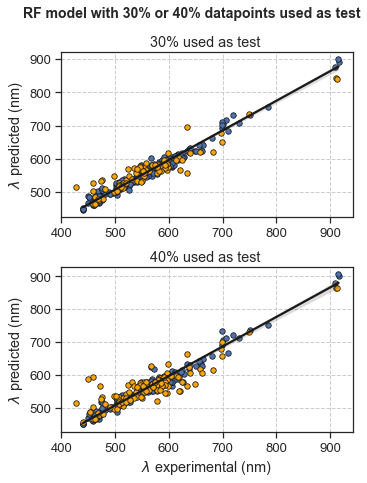

In [7]:
# Matplot to graph test including outlier window. IMPORTANT! Run the previous section with the best model first

sb.set(font_scale=1.2, style="ticks") #set styling preferences

Plotdata_train_30 = {'y_train_30': y_train_30, 'y_pred_RF_train_30': y_pred_RF_train_30} 
Plotdata_test_30 = {'y_test_30': y_test_30, 'y_pred_RF_test_30': y_pred_RF_test_30}

df_train_30 = pd.DataFrame.from_dict(Plotdata_train_30)
df_test_30 = pd.DataFrame.from_dict(Plotdata_test_30)

Plotdata_train_40 = {'y_train_40': y_train_40, 'y_pred_RF_train_40': y_pred_RF_train_40} 
Plotdata_test_40 = {'y_test_40': y_test_40, 'y_pred_RF_test_40': y_pred_RF_test_40}

df_train_40 = pd.DataFrame.from_dict(Plotdata_train_40)
df_test_40 = pd.DataFrame.from_dict(Plotdata_test_40)

# Build the plot
# Set up some features to plot the dots
color_train = 'b'
color_test = 'orange'
size = 30
alpha = 1 # from 0 (transparent) to 1 (opaque)

# Create subplot with a certain size and title
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7))
fig.suptitle('RF model with 30% or 40% datapoints used as test', fontweight='bold', fontsize=14, y=0.97, x=0.58)

# This adjust the distance from the left side and from each plot
plt.subplots_adjust(left=0.32,hspace=0.3)

# Title of each subset
ax1.title.set_text("30% used as test ")
ax2.title.set_text("40% used as test ")

# Plot the data for 30% and 40%
points_train = ax1.scatter(df_train_30["y_train_30"], df_train_30["y_pred_RF_train_30"],
             c = color_train, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha)

points_test = ax1.scatter(df_test_30["y_test_30"], df_test_30["y_pred_RF_test_30"],
             c = color_test, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha)

points_train = ax2.scatter(df_train_40["y_train_40"], df_train_40["y_pred_RF_train_40"],
             c = color_train, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha)

points_test = ax2.scatter(df_test_40["y_test_40"], df_test_40["y_pred_RF_test_40"],
             c = color_test, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha)

# Add the regression line with a confidence interval based on the training sets
plot = sb.regplot("y_train_30", "y_pred_RF_train_30", data=df_train_30, scatter=False, color=".1", 
                  truncate = True, ax=ax1)

plot = sb.regplot("y_train_40", "y_pred_RF_train_40", data=df_train_40, scatter=False, color=".1", 
                  truncate = True, ax=ax2)

# Title of the graph and axis
plot = ax1.set(ylabel='$\lambda$ predicted (nm)', xlabel=None)
plot = ax2.set(ylabel='$\lambda$ predicted (nm)', xlabel='$\lambda$ experimental (nm)')
# plt.text(-3, 57,'$\lambda$ predicted (nm)', rotation=90)

# Prints a summary of statistical values. The same number are obtained in Excel (tested just in case, since
# the R2 obtained from r2_score in sklearn is different than the R2 calculated with the Stats python package and Excel)
print("\nWith",round(i_30*100,2),"% used as test:",
      "\nR2_train =", round(r2_RF_train_30,2), "; MAE_train =", round(mae_RF_train_30,2), "; SD_train =", round(SD_train_30,2), "; RMSE_train =", round(rmse_RF_train_30,2), " nm.",
      "\nR2_test =", round(r2_RF_test_30,2), "; MAE_test =", round(mae_RF_test_30,2), "; SD_test =", round(SD_test_30,2), "; RMSE_test =", round(rmse_RF_test_30,2), " nm.")

print("\nWith",round(i_40*100,2),"% used as test:",
      "\nR2_train =", round(r2_RF_train_40,2), "; MAE_train =", round(mae_RF_train_40,2), "; SD_train =", round(SD_train_40,2), "; RMSE_train =", round(rmse_RF_train_40,2), " nm.",
      "\nR2_test =", round(r2_RF_test_40,2), "; MAE_test =", round(mae_RF_test_40,2),"; SD_test =", round(SD_test_40,2),  "; RMSE_test =", round(rmse_RF_test_40,2), " nm.")


# Add gridlines
ax1.grid(linestyle='--', linewidth=1)
ax2.grid(linestyle='--', linewidth=1)

# If you want to save the plot a png image, type True
graph = True
if graph != False:
 plt.savefig('RF_model_with_test_30.png', dpi=400)

plt.show()


In [9]:
# Use all the points in the model to predict new points

new_smiles = ['O=C1N[Ir]2([N+]3=C1C=CC=C3)(C4=C5C(F)=CC(F)=C4)([N+]6=CC=CC=C65)[N+]7=CC=CC=C7C8=C2C=C(F)C=C8F',
              'O=C1N[Ir]2([N+]3=C1C=CC=C3)(C4=C5C(F)=CC(F)=C4)([N+]6=CC(C(F)(F)F)=CC=C65)[N+]7=CC(C(F)(F)F)=CC=C7C8=C2C=C(F)C=C8F',
              'FC1=CC([Ir]2([N+]3=CC(C(F)(F)F)=CC=C34)(C5=C6C(F)=CC(F)=C5)([N+]7=CC(C(F)(F)F)=CC=C76)C8=CC(F)=CC(F)=C8C9=[N+]2C=C(C(F)(F)F)C=C9)=C4C(F)=C1']

# Generate all the fingerprints with the optimized parameters
fp_descriptors_new_points = []
if best_fp_type == 'Morgan':
    for i in range(len(new_smiles)):
        smi = new_smiles[i]
        if str(smi) != 'nan' and str(smi) != 'None':
            fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smi), radius=int(best_radius), nBits = int(best_bits))
            arr = np.zeros((0,), dtype=np.int8)
            fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
            fp_descriptors_new_points.append(arr)

if best_fp_type == 'RDKit':
    for i in range(len(new_smiles)):
        smi = new_smiles[i]
        if str(smi) != 'nan' and str(smi) != 'None':
            fp = Chem.RDKFingerprint(Chem.MolFromSmiles(smi), maxPath=int(best_radius), fpSize=int(best_bits))
            arr = np.zeros((0,), dtype=np.int8)
            fp_np = DataStructs.ConvertToNumpyArray(fp, arr)
            fp_descriptors_new_points.append(arr)

y_pred_RF_new_points = RF.predict(fp_descriptors_new_points)
print(y_pred_RF_new_points)

[495.74 514.5  508.62]
